# Performance Analysis of KOOC for a Simple Pendulum

In this notebook, we demonstrate Koopman Operator Optimal Control (KOOC) for a simple pendulum, globally linearized using a Linearly Recurrent Encoder Network (LREN) and a Deep Encoder with Initial State parameterisation network (DENIS). The performance difference between the two is compared. We also utilize a local linearization control method i.e. iterative LQR (iLQR) and model predictive control (MPC) on the Koopman Invariant Subspace.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import interpolate, signal
from scipy.integrate import odeint
import harold
from control import *
import torch


os.chdir("../")

from helper_fn import *
plt.rcParams.update({'font.size': 22})
%load_ext autoreload
%autoreload 2

## DENIS VS LREN Open Loop Comparision

The pendulum is simulated without control input

In [130]:
val_data = torch.tensor(np.load("data/pendulum_val.npy")).float()
denis = torch.load("logs/denis_pendulum/model-denis-pend-best.pt", map_location=torch.device('cpu'))
lren = torch.load("logs/lren_pendulum/model-lren-pend-best.pt", map_location=torch.device('cpu'))

/anaconda3/envs/DKoopman/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'networks.LREN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/anaconda3/envs/DKoopman/lib/python3.7/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [131]:
enc_gt_de, enc_traj_de, ko_all = denis(val_data)
enc_gt_lr, enc_traj_lr = lren(val_data)
val_data = val_data.detach().numpy()

In [312]:
idx = np.random.randint(val_data.shape[0])
init = val_data[idx, 0, :]
#init = [1.5, 1.]
print("Random Initial: {}".format(init))

Random Initial: [1.895733  0.6782752]


In [313]:
# get initial encodings
enc_init_de = enc_traj_de[idx, 0, :].detach().numpy()
enc_init_lr = enc_traj_lr[idx, 0, :].detach().numpy()

# get koopman operators
ko = ko_all[idx].detach().numpy()
ko_lren = list(lren.parameters())[-1].detach().numpy()

pred_de = [enc_init_de]
pred_lr = [enc_init_lr]
n_steps = 500

for i in range(n_steps):
    pred_de.append(np.matmul(pred_de[-1], ko))
    pred_lr.append(np.matmul(pred_lr[-1], np.transpose(ko_lren)))
    
pred_de = np.asarray(pred_de)[:, :2]
pred_lr = np.asarray(pred_lr)[:, :2]

t = np.arange(0, n_steps*0.1+0.1, 0.1)

Equvalent to ODE45 in MATLAB so solve for the pendulum system

In [314]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, - c*np.sin(theta)]
    return dydt

b = 0.25
c = 1.0
y0 = init

sol = odeint(pend, y0, t, args=(b, c))

We see clearly that DENIS outperforms LREN with open loop

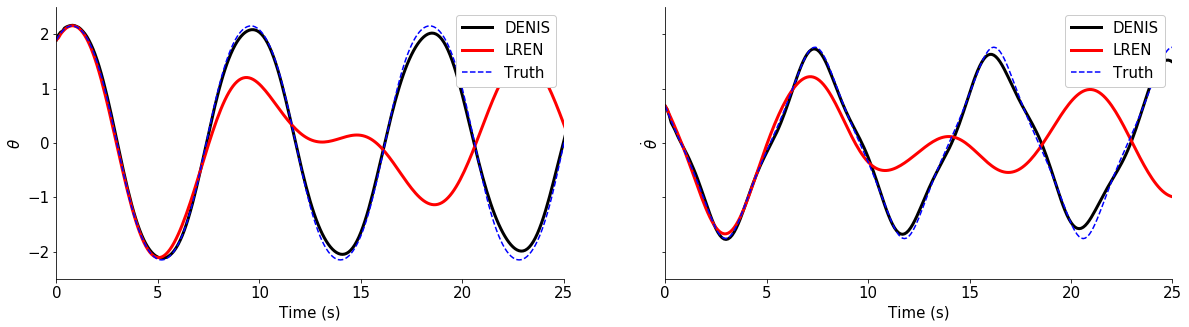

In [315]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5), sharex=True, sharey=True)

ax[0].plot(t, pred_de[:,0], label=r"DENIS", linewidth=3, color='k')
ax[0].plot(t, pred_lr[:,0], label=r"LREN", linewidth=3, color='r')
ax[0].plot(t, sol[:,0],'--', label=r"Truth", color='b')

ax[1].plot(t, pred_de[:,1], label=r"DENIS", linewidth=3, color='k')
ax[1].plot(t, pred_lr[:,1], label=r"LREN", linewidth=3, color='r')
ax[1].plot(t, sol[:,1], '--', label=r"Truth", color='b')

ax[0].set_ylabel(r"$\theta$")
ax[1].set_ylabel(r"$\dot{\theta}$")

for i in range(2):
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].legend(loc=1, facecolor='white', framealpha=1)
    ax[i].set_xlim([0, 25])
    ax[i].set_ylim([-2.5, 2.5])
    ax[i].set_xlabel("Time (s)")

plt.savefig('figures/denis_vs_lh_1d.png', bbox_inches='tight', dpi=200)
plt.show()

Animation generation for the two systems

## Close Loop Control via LQR (KOOC)

First, we use Tustin transform to convert our discrete system into a continous system, sampling time set to system's time-advance steps

In [316]:
A_de = np.transpose(ko.copy())
#A_de = ko.copy()
A_lr = np.transpose(ko_lren.copy())
dim = 2

ldim_de = len(enc_init_de) - dim
ldim_lr = len(enc_init_lr) - dim

Ts = 0.1

B_de = np.append([0, 1], np.zeros((1, ldim_de)))[:, np.newaxis]
B_lr = np.append([0, 1], np.zeros((1, ldim_lr)))[:, np.newaxis]

C_de = np.append([1, 1], np.zeros((1, ldim_de)))
C_lr = np.append([1, 1], np.zeros((1, ldim_lr)))

#dsys_de = signal.StateSpace(A_de, B_de, C_de, .0, dt=Ts)
#dsys_lr = signal.StateSpace(A_lr, B_lr, C_lr, .0, dt=Ts)

G_de = harold.State(A_de, B_de, C_de, .0, dt=Ts)
G_lr = harold.State(A_lr, B_lr, C_lr, .0, dt=Ts)

sys_de = harold.undiscretize(G_de, 'tustin')
sys_lr = harold.undiscretize(G_lr, 'tustin')

As_de = sys_de.a
As_lr = sys_lr.a

Eigenvalues are visualized, we expect pair wise eigenvalues $\pm j$ which corresponds to the pure rotation term

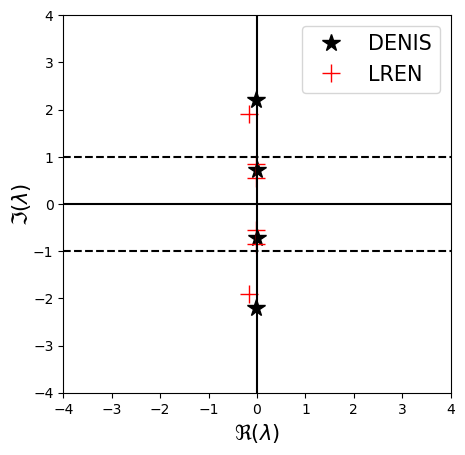

In [317]:
eigA_de = np.linalg.eig(As_de)[0]
eigA_lr = np.linalg.eig(As_lr)[0]

plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(5,5), dpi=100)
plt.plot(np.real(eigA_de), np.imag(eigA_de), '*', label='DENIS', color='k', markersize=13)
plt.plot(np.real(eigA_lr), np.imag(eigA_lr), '+', label='LREN', markersize=13, color='r')


plt.axvline(x=0, color='k')
plt.axhline(y=0, color='k')
plt.axhline(y=1, linestyle='dashed', color='k')
plt.axhline(y=-1, linestyle='dashed', color='k')

plt.xlabel(r"$\Re(\lambda)$")
plt.ylabel(r"$\Im(\lambda)$", labelpad=0)
plt.tick_params(axis='both', which='major', labelsize=10)

plt.xlim([-4, 4])
plt.ylim([-4, 4])
#plt.xticks([-100, -50, 0])
#plt.yticks(np.arange(-100, 150, 50))

plt.legend(loc=1)
plt.savefig('figures/denis_vs_lh_eigenvalues_zoomed.png', bbox_inches='tight', dpi=200)

plt.show()

In [318]:
from control import *

Q_de = np.zeros((A_de.shape));
Q_de[0,0] = 1;
Q_de[1,1] = 1;

Q_lr = np.zeros((A_lr.shape));
Q_lr[0,0] = 1;
Q_lr[1,1] = 1;

B_de = np.append([0, 1], np.zeros((1, ldim_de)))[:, np.newaxis]
B_lr = np.append([0, 1], np.zeros((1, ldim_lr)))[:, np.newaxis]

K_de, S_de, E_de = lqr(As_de, B_de, Q_de, 1)

denis.params['n_shifts'] = 1
lren.params['n_shifts'] = 1
K_lr, S_lr, E_lr = lqr(As_lr, B_lr, Q_lr, 1.)

In [319]:
def pendulum_de(y, t, K):
    phi, omega = y
    y_tensor = torch.tensor(y, dtype=torch.float32).view((1, 1, 2))
    _, enc_traj, _ = denis(y_tensor)
    latent = enc_traj[0, -1, :].detach().numpy()
    u = K.dot(latent)[0, 0]
    t_u_de.append(t)
    de_u.append(u)
    dydt = [omega, -np.sin(phi) - u]
    return dydt

def pendulum_lr(y, t, K):
    phi, omega = y
    y_tensor = torch.tensor(y, dtype=torch.float32).view((1, 1, 2))
    _, enc_traj = lren(y_tensor)
    latent = enc_traj[0, -1, :].detach().numpy()
    u = K.dot(latent)[0, 0]
    t_u_lr.append(t)
    lr_u.append(u)
    dydt = [omega, -np.sin(phi) - u]
    return dydt

In [320]:
dt = 0.1
N = 101
t1 = np.arange(0, dt*(N+1), dt)

In [321]:
y0 = init.copy()
de_u = []
lr_u = []
t_u_lr = []
t_u_de = []

sol_de = odeint(pendulum_de, y0, t1, args=(K_de,))
sol_lr = odeint(pendulum_lr, y0, t1, args=(K_lr,))

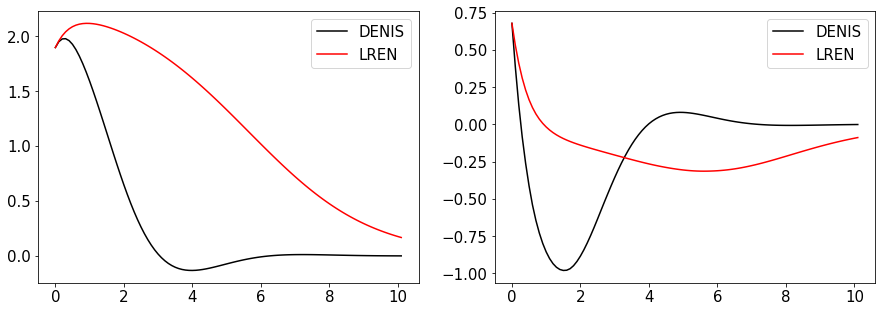

In [322]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
ax[0].plot(t1, sol_de[:, 0], 'k', label='DENIS')
ax[0].plot(t1, sol_lr[:, 0], 'r', label='LREN')
ax[0].legend()

ax[1].plot(t1, sol_de[:, 1], 'k', label='DENIS')
ax[1].plot(t1, sol_lr[:, 1], 'r', label='LREN')
ax[1].legend()

plt.savefig('figures/denis_vs_lh_kooc.png', bbox_inches='tight', dpi=200)
plt.show()

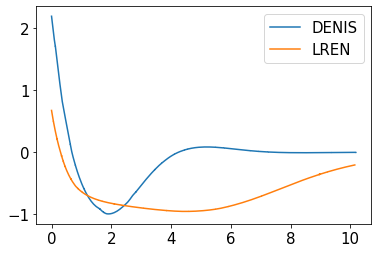

In [323]:
plt.plot(t_u_de, de_u, label='DENIS')
plt.plot(t_u_lr, lr_u, label='LREN')
plt.legend()
plt.show()

## Close Loop Control via iLQR (KOOC)

We benchmark globally linearized optimal control method, i.e. KOOC against locally linearized method i.e. iterative LQR. As the encoding of the trajectory is not perfect, we suspect that KOOC is worse than iLQR

In [324]:
from ilqr_pendulum import *

In [325]:
# Initialize pendulum dynamics
dt = 0.1
dynamics = ilqr_pend(dt)
cost = pend_cost()

N = 101  # Number of time-steps in trajectory.
x0 = y0.copy()  # Initial state.
us_init = np.random.uniform(-1, 1, (N, 1)) # Random initial action path.

ilqr = iLQR(dynamics, cost, N)
xs, us = ilqr.fit(x0, us_init)
t = np.arange(0, dt*(N+1), dt)

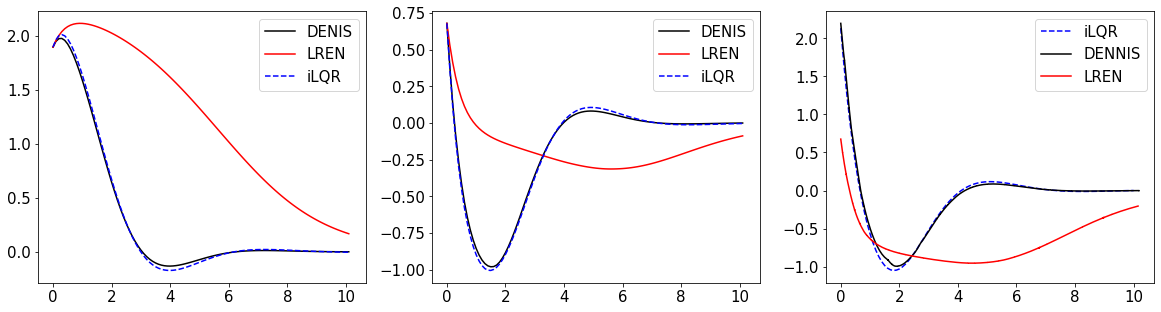

In [326]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
ax[0].plot(t1, sol_de[:, 0], 'k', label='DENIS')
ax[0].plot(t1, sol_lr[:, 0], 'r', label='LREN')
ax[0].plot(t, xs[:,0], '--b', label='iLQR')
ax[0].legend()

ax[1].plot(t1, sol_de[:, 1], 'k', label='DENIS')
ax[1].plot(t1, sol_lr[:, 1], 'r', label='LREN')
ax[1].plot(t, xs[:,1], '--b', label='iLQR')
ax[1].legend()

ax[2].plot(t[:-1], us, '--b', label='iLQR')
ax[2].plot(t_u_de, de_u, 'k', label='DENNIS')
ax[2].plot(t_u_lr, lr_u, 'r', label='LREN')
ax[2].legend()

plt.savefig('figures/denis_vs_lh_kooc_vs_lqr_3.png', bbox_inches='tight', dpi=200)
plt.show()

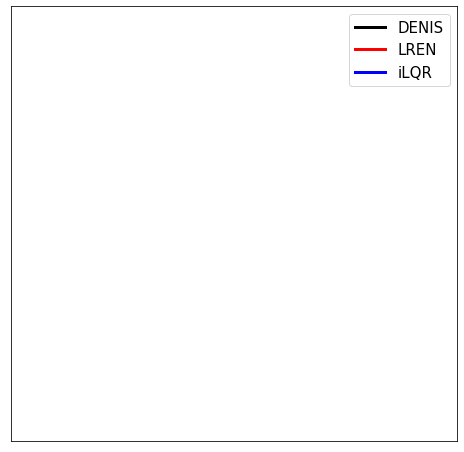

In [327]:
import matplotlib.animation as animation
fig = plt.figure(figsize=(8, 8), facecolor='w')
ax = fig.add_subplot(1, 1, 1)
plt.rcParams['font.size'] = 15
ax.set_xlim([-1, 1])
ax.set_ylim([-2, 2])
ax.set_yticks([])
ax.set_xticks([])
lns = []

for i in range(len(sol_de)):
    ln, = ax.plot([0, np.sin(sol_de[i, 0])], [0, -np.cos(sol_de[i, 0])],
                  color='k', lw=3, label="DENIS" if i == 0 else "")
    
    ln1, = ax.plot([0, np.sin(sol_lr[i, 0])], [0, -np.cos(sol_lr[i, 0])],
                  color='r', lw=3, label="LREN" if i == 0 else "")
    
    ln2, = ax.plot([0, np.sin(xs[i, 0])], [0, -np.cos(xs[i, 0])],
                  color='b', lw=3, label="iLQR" if i == 0 else "")

    #tm = ax.text(-1, 0.9, 'time = %.1fs' % t1[i])
    lns.append([ln, ln1, ln2, tm])
ax.set_aspect('equal', 'datalim')
ax.legend()


interval=50
ani = animation.ArtistAnimation(fig, lns, interval=interval)
fn = 'figures/pendulum_controlled_ilqr_3'
ani.save(fn+'.mp4',writer='ffmpeg')

In [335]:
lns[0]

 Text(-1, 0.9, 'time = 10.1s')]